In [33]:
import torch
import json
import numpy as np

In [46]:
# LOAD FINE-TUNED MODEL FROM DISK

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = torch.load('./torch-cache/test.ckpt', map_location=torch.device('cpu'))
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

with open('./torch-cache/authors.json') as file:
    authors = json.load(file)
    print(f"Authors list: {authors}")

Total number of parameters: 109489161
Authors list: ['shakespeare', 'jonson', 'fletcher', 'ford', 'rowley', 'middleton', 'massinger', 'dekker', 'webster']


In [48]:
# PORT OF PREPROCESSING SCRIPT USED ON CORPUS

import re
from typing import List

def process_line(line: str) -> str:
    result = line

    # Remove stuff between brackets
    bracket_processed = False
    if '[' in line and ']' in line:
        fst_bracket_idx = line.index('[')
        snd_bracket_idx = line.index(']')
        if fst_bracket_idx < snd_bracket_idx:
            result = result[:fst_bracket_idx] + result[snd_bracket_idx + 1:]
            bracket_processed = True
    if not bracket_processed and '[' in line:
        fst_bracket_idx = line.index('[')
        result = result[:fst_bracket_idx]
        bracket_processed = True
    if not bracket_processed and ']' in line:
        snd_bracket_idx = line.index(']')
        result = result[snd_bracket_idx + 1:]
        bracket_processed = True

    # Remove symbols and ALL CAPS words, and normalize punctuation
    result = re.sub(r"[’‘]", "'", result)
    result = re.sub(r"[_,:;\[\]\{\}\(\)—“”&<>$/\\=+\`^]", '', result)
    result = re.sub(r"[0-9]", '', result)
    result = result.replace('-', ' ')
    result = re.sub(r"[\?\!]", '.', result)

    words = result.split(' ')
    words = [word for word in words if not (word.isupper() and len(word) > 1)]
    result = ' '.join(words)

    return result

def process_text(text: str) -> List[str]:
    # Remove excess white space and process each line
    lines = text.split('\n')
    lines = [line.strip() for line in lines]
    lines = [process_line(line) for line in lines]
    lines = [line for line in lines if line]
    result = ' '.join(lines)

    # Clean up sentences
    sentences = result.split('.')
    sentences = [sentence.strip().lower() for sentence in sentences]
    sentences = [sentence.split(' ') for sentence in sentences]
    sentences = [[token for token in tokens if token] for tokens in sentences]
    sentences = [
        [word for word in tokens if not (len(word) == 1 and word in [
            'b', 'c', 'f', 'g', 'h', 'j', 'k',
            'p', 'q', 'r', 'v', 'w', 'x', 'y', 'z'
        ])]
        for tokens in sentences
    ]
    sentences = [' '.join(tokens) for tokens in sentences if len(tokens) > 2]

    return sentences

In [83]:
# FORMAT INFERENCE INPUT (RAW COPY PASTE) INTO BERT INPUT and MASK

sentence = """Win, I have heard the news; all now is safe;
The worst is past: thy lip, wench [_Kisses her_]: I must bid
Farewell, for fashion's sake; but I will visit thee
Suddenly, girl. This was cleanly carried;
Ha! was't not, Win?

_Win._              Then were my happiness,
That I in heart repent I did not bring him
The dower of a virginity. Sir, forgive me;
I have been much to blame: had not my lewdness[413]
Given way to your immoderate waste of virtue,
You had not with such eagerness pursued
The error of your goodness."""

tokens = [t for sublist in [s.split(" ") for s in process_text(sentence)] for t in sublist]

MAX_SEQUENCE_LEN = 128
current_input = ["CLS"]
current_input.extend(tokens[0:min(MAX_SEQUENCE_LEN - 2, len(tokens))])
current_input.append("[SEP]")
mask = [1 for _ in range(len(current_input))]
while len(current_input) != MAX_SEQUENCE_LEN:
    current_input.append("[PAD]")
    mask.append(0)
inputs = tokenizer.convert_tokens_to_ids(current_input)

In [84]:
# RUN INFERENCE

x_inputs = torch.tensor(inputs).unsqueeze(0)
x_masks = torch.tensor(mask).unsqueeze(0)

model.eval()
outputs = model(x_inputs, token_type_ids=None, attention_mask=x_masks, output_attentions=True) 
logits = outputs.logits
print(logits)

tensor([[-1.4312, -0.5558, -2.2778,  0.5206,  2.4747,  0.0420,  0.1549,  0.7542,
          1.6285]], grad_fn=<AddmmBackward0>)


/var/folders/7v/0_wky4w91lq6lypg_14n4gr80000gn/T/ipykernel_4753/277242102.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = np.array(F.softmax(logits).detach().numpy()[0])


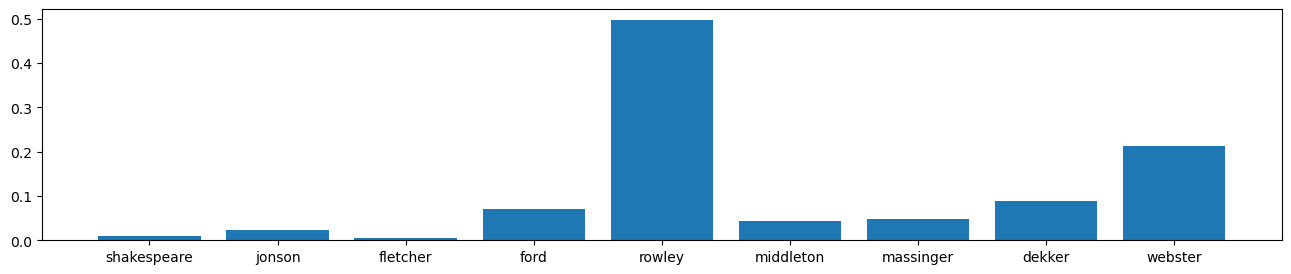

In [85]:
# PLOT CLASSIFICATION LOGITS

import torch.nn.functional as F
import matplotlib.pyplot as plt

x = np.array(authors)
y = np.array(F.softmax(logits).detach().numpy()[0])

plt.figure(figsize=(16, 3))
plt.bar(x,y)
plt.show()